<a href="https://colab.research.google.com/github/anniepeacock/DANSAR/blob/devel/nisar/Fire_NISAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# NISAR Application: Wildfires

### Corresponding Story Map: https://arcg.is/14GG400

### I. How to create SAR images of wildfires?

* Useful Products: HV Ratio, HV Difference, RVI, RFDI
* Useful Wavelengths: HV
* Instructions to View: Use pre and post-fire images to generate an HV ratio

### II. How to interpret SAR images of wildfires?
One of the ways to monitor wildfire is to map the loss of vegetation, and SAR can be leveraged to detect changes in ground cover after a fire for fire extent detection and mapping.

NISAR is a radar instrument collecting data in the L-band wavelength. In L-band, the radar waves penetrate the vegetation canopy and interact with trunks, large branches, tree stems, and the forest floor. As leaves and branches are removed during a fire, the signal return or "backscatter" decreases in the radar images.

## SAR Example: La Tuna Fire

The examples below demonstrate radar's sensitivity to changes in vegetation cover from the 2017 La Tuna Fire, which burned 29 square kilometers in the Verdugo Mountains and is the largest recorded fire in the city of Los Angeles. The data is from NASA JPL's UAVSAR, an airborne radar and NISAR testbed instrument.

---------------------------------------------------------------------------

**Example 1** : [Fire Change Detection](#s3)

**Example 2**: [Time Series](#s4)

**Example 3**: [RGB Multi-Temporal Composite](#s2)

<a name="s1"></a>
## 0. Running the Notebook
This Google Colab notebook has a mix of text and code cells. If you would like to explore the code, this notebook can be run in a web browser without any additional set-up.

To run the content in the code cells, **select the play button** in the left corner of each code cell. To avoid any errors, all cells must be run in order. Code cells are either light gray and can be expanded with the drop-down arrow (to the right of this cell) or with the "Show code" button for the examples below.



### Install and Import Required Python Packages:
This routine uses the following python libraries. Some are already included in the Google Colab environment and others are installed in the cell below. Downloading new python packages to this environment may take a minute to complete.

In [36]:
## The packages may take a minute to install
!pip install rasterio --quiet
!pip install rasterstats --quiet
!pip install geopandas --quiet

import rasterio as rio                    # Read and write geospatial raster data
import rasterio.plot                      # Plotting raster data
from rasterio.plot import show            # Show raster plots
import rasterstats as rs                  # Zonal statistics of rasters
from rasterio.plot import plotting_extent # Returns plotting extent in format needed
import geopandas as gpd                   # Visualizing and importing geodata frames
from geopandas import GeoDataFrame
import pandas as pd                       # Visualizing and importing data frames

import math                               # Access to mathematical functions
import numpy as np                        # Numeric and mathematic functions

import matplotlib.pyplot as plt           # Plotting, making graphs
from matplotlib.pyplot import xticks      # Tick functionality on graph
import plotly.graph_objects as go         # Plotting, making graphs with plotly (interactive)
from skimage.measure import profile_line  # Retrieve profile along a line
from matplotlib.patches import Patch
from matplotlib.colors import Normalize

from scipy.ndimage.filters import uniform_filter # For Lee Filter
from scipy.ndimage.measurements import variance  # For Lee Filter

<ipython-input-36-f63942e225d3>:24: DeprecationWarning: Please use `uniform_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import uniform_filter # For Lee Filter
<ipython-input-36-f63942e225d3>:25: DeprecationWarning: Please use `variance` from the `scipy.ndimage` namespace, the `scipy.ndimage.measurements` namespace is deprecated.
  from scipy.ndimage.measurements import variance  # For Lee Filter


### Download and Read in the Data:

Fetch UAVSAR L-Band airborne SAR geotiffs from the download links below with wget. These files will download to this Google Colab instance and are accessible by clicking the folder icon on the left side panel. The original UAVSAR data have been converted to geotiff and cropped to the Verdugo Mountains and surrounding urban area.

In [37]:
## La Tuna Fire Stack HV 2009 - 2021 with burn/not burn
!wget https://uavsar.jpl.nasa.gov/SAR_NOTEBOOKS/Fire/stack_fire.tif --quiet
!wget https://uavsar.jpl.nasa.gov/SAR_NOTEBOOKS/Fire/6m.tif  --quiet
!wget https://uavsar.jpl.nasa.gov/SAR_NOTEBOOKS/Fire/6m_stack.tif  --quiet

!wget https://uavsar.jpl.nasa.gov/SAR_NOTEBOOKS/Fire/latuna_perimeter.geojson --quiet
!wget https://uavsar.jpl.nasa.gov/SAR_NOTEBOOKS/Fire/unburnt_verdugo.geojson --quiet
!wget https://uavsar.jpl.nasa.gov/SAR_NOTEBOOKS/Fire/verdugos.geojson --quiet

Open a curated UAVSAR data stack from the UAVSAR website. This data is at 6 meter resolution and cropped to the Verdugo Mountains.

In [38]:
stack = rio.open('stack_fire.tif')
stack = stack.read((1,2,3,4,5,6,7,8,9,10))

# Read in stack's bands
hv2009 = stack[0, 0:, 0:] # UAVSAR HV 2009
hv2010 = stack[1, 0:, 0:] # UAVSAR HV 2009
hv2011 = stack[2, 0:, 0:] # UAVSAR HV 2009
hv2012 = stack[3, 0:, 0:] # UAVSAR HV 2009
hv2014 = stack[4, 0:, 0:] # UAVSAR HV 2009
hv2017 = stack[5, 0:, 0:] # UAVSAR HV 2009
hv2018 = stack[6, 0:, 0:] # UAVSAR HV 2009
hv2020 = stack[7, 0:, 0:] # UAVSAR HV 2009
verdugos = stack[8, 0:, 0:] # Mask of Verdugo Mountain extent outside of the fire scar
perimeter = stack[9, 0:, 0:] # Mask of fire scar extent in the Verdugo Mountains

dnbr_layer = rio.open('6m.tif').read((1,2,3,4,5))
dnbr = dnbr_layer[2, 0:, 0:] # dNBR (normalized difference burn index derived fromo Landsat)

Apply a 5x5 speckle Lee filter to the UAVSAR data

In [39]:
def lee_filter(img, size):
    img_mean = uniform_filter(img, (size, size))
    img_sqr_mean = uniform_filter(img**2, (size, size))
    img_variance = img_sqr_mean - img_mean**2

    overall_variance = variance(img)

    img_weights = img_variance / (img_variance + overall_variance)
    img_output = img_mean + img_weights * (img - img_mean)
    return img_output

lee_hv2009 = lee_filter(hv2009, 5)
lee_hv2010 = lee_filter(hv2010, 5)
lee_hv2011 = lee_filter(hv2011, 5)
lee_hv2012 = lee_filter(hv2012, 5)
lee_hv2014 = lee_filter(hv2014, 5)
lee_hv2017 = lee_filter(hv2017, 5)
lee_hv2018 = lee_filter(hv2018, 5)
lee_hv2020 = lee_filter(hv2020, 5)

<a name="s3"></a>
## 1. Fire Change Detection
This example uses the HV polarization due to HV's sensitivity to vegetation change from before and after the fire. HV correlates with biomass and canopy volume and is primarily sensitive to volume scattering. Volume scattering decreases as vegetation is replaced with bare ground after a fire.

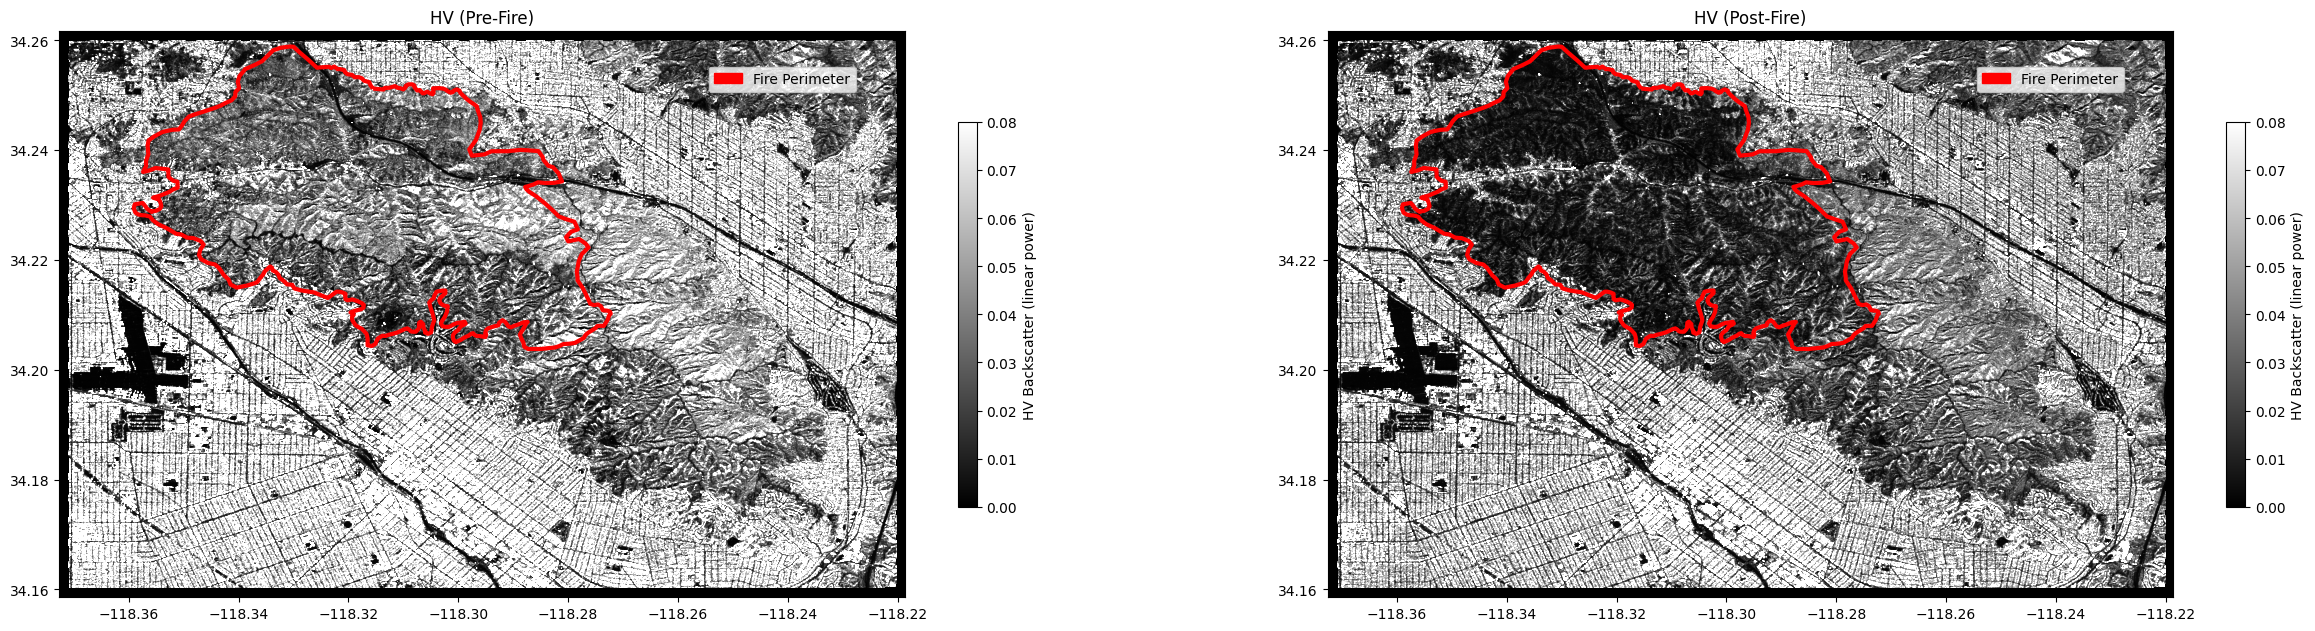

In [41]:
#@title Plot HV Pre and Post Fire
fig,(ax1, ax2) = plt.subplots(1,2, figsize=(30,10))

vmin = 0
vmax = 0.08

with rio.open('6m_stack.tif') as subset_src: #getting reference extent
    subset_extent = plotting_extent(subset_src)
    trans = subset_src.transform
fire_perimeter = gpd.read_file('latuna_perimeter.geojson')
fire_perimeter = fire_perimeter["geometry"]
fire_boundary = fire_perimeter.to_crs(subset_src.crs)
fire_boundary.plot(edgecolor='red', facecolor='none', linewidth=3, ax=ax1)
fire_boundary.plot(edgecolor='red', facecolor='none', linewidth=3, ax=ax2)

# Add a legend for labels
legend_labels = {"red": "Fire Perimeter"}
patches = [Patch(color=color, label=label)
           for color, label in legend_labels.items()]
ax1.legend(handles=patches,
          bbox_to_anchor=(0.95, 0.95),
          facecolor="white")
ax2.legend(handles=patches,
          bbox_to_anchor=(0.95, 0.95),
          facecolor="white")

cmap = "gray"
plot = ax1.imshow(hv2014.squeeze(), vmin=vmin, vmax=vmax, cmap=cmap, extent=subset_extent)
ax1.set_title('HV (Pre-Fire)')
cbar=fig.colorbar(plot, ax=ax1, shrink=0.5)
cbar.set_label('HV Backscatter (linear power)')

plot = ax2.imshow(hv2017.squeeze(), vmin=vmin, vmax=vmax, cmap=cmap, extent=subset_extent)
ax2.set_title('HV (Post-Fire)')
cbar=fig.colorbar(plot, ax=ax2, shrink=0.5)
cbar.set_label('HV Backscatter (linear power)')

SAR's HV polarization is used due to HV's sensitivity to vegetation change and transects from images pre and post fire can be used to compare changes in HV backscatter values between areas burnt in the fire and unburnt areas. Burnt areas should have decreased HV backscatter.

The figures below show the fire perimeter (red) and perimeter of the unburned portion of the Verdugo Mountains (blue). HV's sensitivity to vegetation change can be leveraged to map fire extent, and HV values visibly decrease (appear darker) in 2017 after the fire. The figure also shows a transect spanning both the fire scar and unburned regions of the Verdugo Mountains. Their discrepancy highlights how the HV values changed pre and post fire.

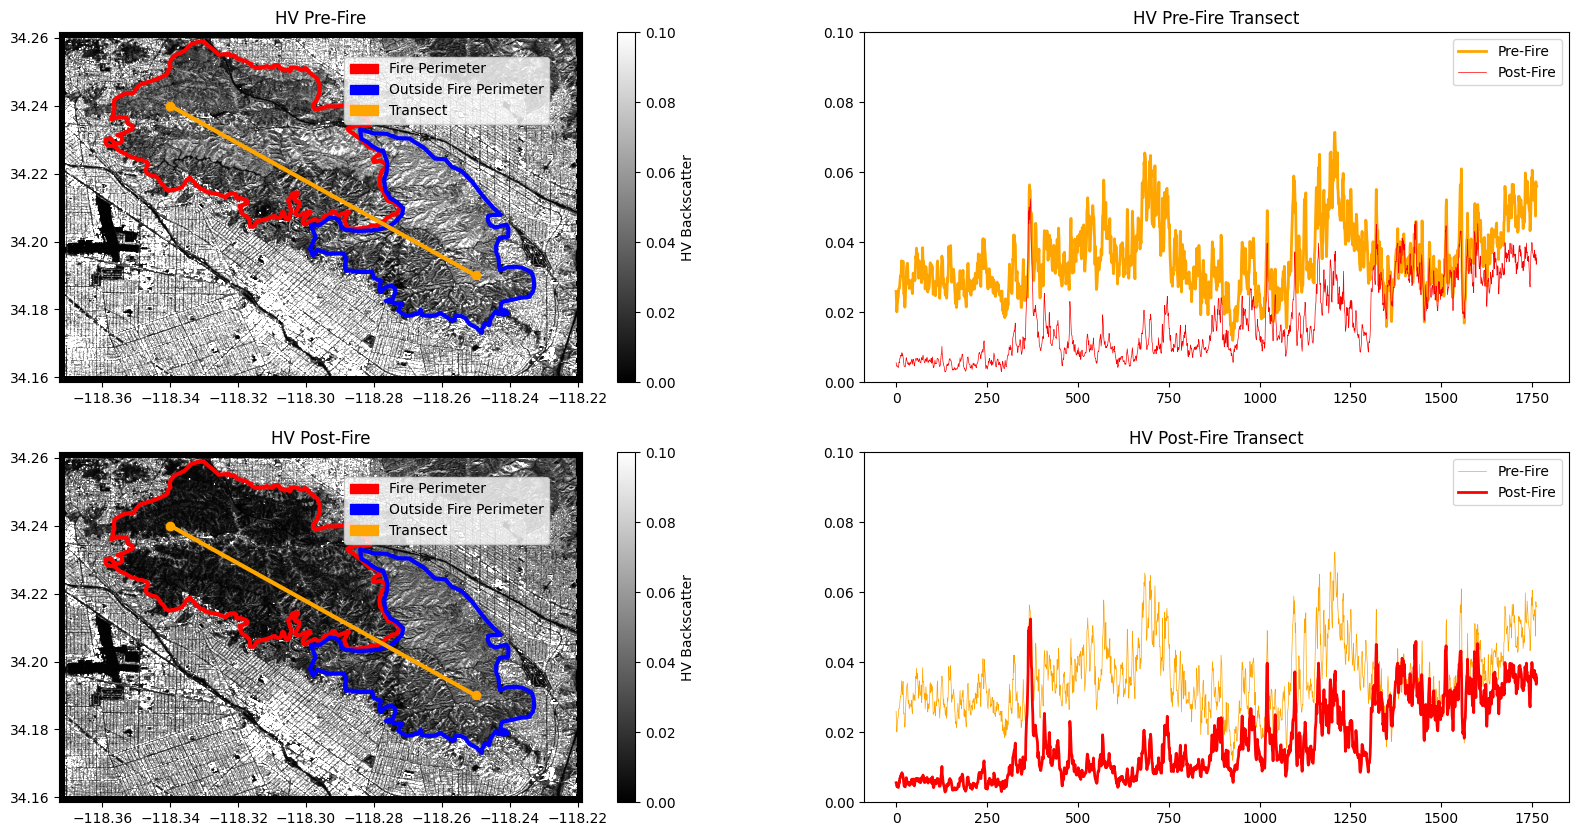

In [42]:
#@title Plot Pre-Fire and Post-Fire with the HV Image

# Specify start/stop of the pixel coordinates for plot transect
x0, y0 = 550, 200
x1, y1 = 2000, 1200
# Generate the transect
transect_prefire = profile_line(hv2014, (y0, x0), (y1, x1), linewidth=100, mode='nearest', reduce_func=np.median)
transect_postfire = profile_line(hv2017, (y0, x0), (y1, x1), linewidth=100, mode='nearest', reduce_func=np.median)

vmin=0
vmax=0.1
x1, y1 = -118.34, 34.24
x0, y0 = -118.25, 34.19
cm = ['viridis','gray']
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))

############## Read in the fire and perimeter geometries ##############
with rio.open('stack_fire.tif') as subset_src: #getting reference extent
    subset_extent = plotting_extent(subset_src)
    trans = subset_src.transform
fire_perimeter = gpd.read_file('latuna_perimeter.geojson')
fire_perimeter = fire_perimeter["geometry"]
fire_boundary = fire_perimeter.to_crs(subset_src.crs)
fire_boundary.plot(edgecolor='red', facecolor='none', linewidth=3, ax=axes[0,0])
fire_boundary.plot(edgecolor='red', facecolor='none', linewidth=3, ax=axes[1,0])

verdugos_perimeter = gpd.read_file('unburnt_verdugo.geojson')
verdugos_perimeter = verdugos_perimeter["geometry"]
verdugos_boundary = verdugos_perimeter.to_crs(subset_src.crs)
verdugos_boundary.plot(edgecolor='blue', facecolor='none', linewidth=3, ax=axes[0,0])
verdugos_boundary.plot(edgecolor='blue', facecolor='none', linewidth=3, ax=axes[1,0])

# Add a legend for labels
legend_labels = {"red": "Fire Perimeter", "blue":"Outside Fire Perimeter", "orange":"Transect"}
patches = [Patch(color=color, label=label)
           for color, label in legend_labels.items()]
axes[0,0].legend(handles=patches,
          bbox_to_anchor=(0.95, 0.95),
          facecolor="white")
axes[1,0].legend(handles=patches,
          bbox_to_anchor=(0.95, 0.95),
          facecolor="white")

############## Pre-Fire Plotting ##############
color = axes[0,0].imshow(hv2014, vmin=vmin, vmax=vmax, cmap=cm[1], extent=subset_extent)
axes[0,0].plot([x0, x1], [y0, y1], 'o-', lw=3, color='orange')
axes[0,0].set_title('HV Pre-Fire')
colorbar = fig.colorbar(color, ax=axes[0, 0])
colorbar.set_label('HV Backscatter')

axes[0,1].plot(transect_prefire, color='orange', linewidth='2')
axes[0,1].plot(transect_postfire, color='red', linewidth='0.5')
axes[0,1].set_ylim([vmin, vmax])
axes[0,1].set_title('HV Pre-Fire Transect')

# Create legend handles for pre-fire and post-fire transect
axes[0, 1].legend(('Pre-Fire', 'Post-Fire'), loc='upper right')

############## Post-Fire Plotting ##############
color = axes[1,0].imshow(hv2017, vmin=vmin, vmax=vmax, cmap=cm[1], extent=subset_extent)
axes[1,0].plot([x0, x1], [y0, y1], 'o-', lw=3, color='orange')
axes[1,0].set_title('HV Post-Fire')
colorbar = fig.colorbar(color, ax=axes[1, 0])
colorbar.set_label('HV Backscatter')

axes[1,1].plot(transect_prefire, color='orange', linewidth='0.5')
axes[1,1].plot(transect_postfire, color='red', linewidth='2')
axes[1,1].set_ylim([vmin, vmax])
axes[1,1].set_title('HV Post-Fire Transect')
axes[1, 1].legend(('Pre-Fire', 'Post-Fire'), loc='upper right')

plt.show()

## Fire Severity Change Detection and Comparison with Optical
A simple ratio of HV images pre and post fire show temporal change. Here, we calculate the HV Ratio and compare with Landsat's dNBR (differenced normalized burn ratio), which is a widely used index for fire-associated change detection based on optical sensors. dNBR is provided for comparison with the HV ratio, as it captures burn area by exploiting the loss of healthy green vegetation, or changes in greenness. Notably, radar is not sensitive to greenness but instead can detect shape and moisture properties, which can allude to fuel properties.

In [43]:
# Find the HV log ratio between 2014 and 2017 UAVSAR acquisitions
HV_log_2014_2017 = np.log(np.divide(lee_hv2014, lee_hv2017))

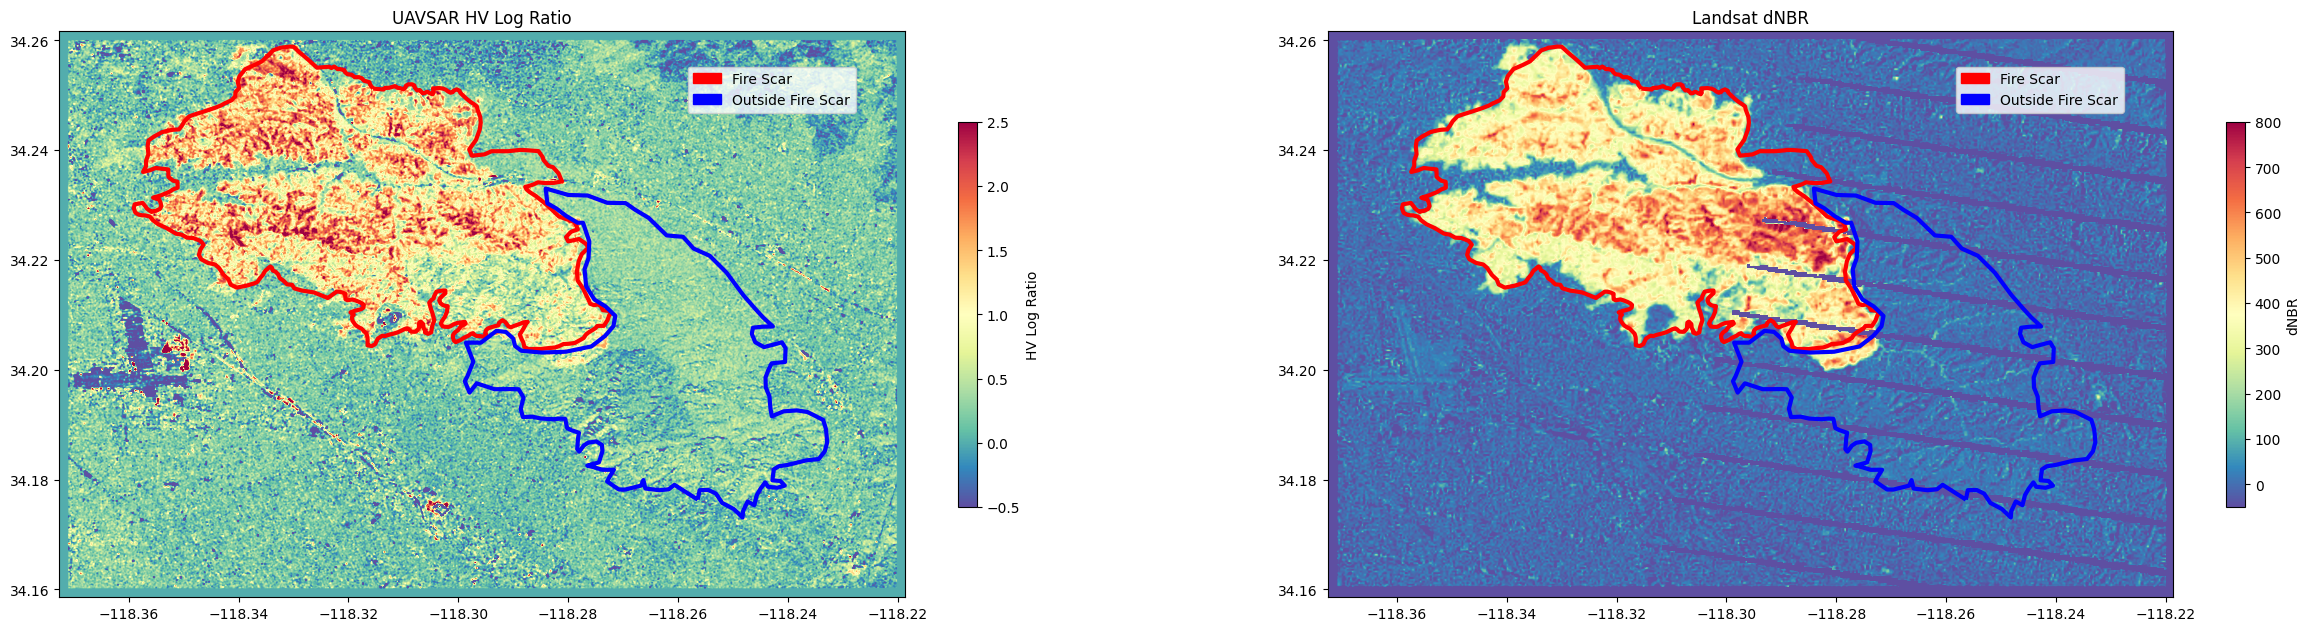

In [44]:
#@title Plot UAVSAR's HV Log Ratio and Landsat dNBR
fig, (ax1, ax2)  = plt.subplots(1,2, figsize=(30,10))

# Add perimeters to plot
with rio.open('stack_fire.tif') as subset_src: #getting reference extent
    subset_extent = plotting_extent(subset_src)
    trans = subset_src.transform
fire_perimeter = gpd.read_file('latuna_perimeter.geojson')
fire_perimeter = fire_perimeter["geometry"]
fire_boundary = fire_perimeter.to_crs(subset_src.crs)
fire_boundary.plot(edgecolor='red', facecolor='none', linewidth=3, ax=ax1)
fire_boundary.plot(edgecolor='red', facecolor='none', linewidth=3, ax=ax2)

verdugos_perimeter = gpd.read_file('unburnt_verdugo.geojson')
verdugos_perimeter = verdugos_perimeter["geometry"]
verdugos_boundary = verdugos_perimeter.to_crs(subset_src.crs)
verdugos_boundary.plot(edgecolor='blue', facecolor='none', linewidth=3, ax=ax1)
verdugos_boundary.plot(edgecolor='blue', facecolor='none', linewidth=3, ax=ax2)

# Add a legend for labels
legend_labels = {"red": "Fire Scar", "blue":"Outside Fire Scar"}
patches = [Patch(color=color, label=label)
           for color, label in legend_labels.items()]
ax1.legend(handles=patches,
          bbox_to_anchor=(0.95, 0.95),
          facecolor="white")
ax2.legend(handles=patches,
          bbox_to_anchor=(0.95, 0.95),
          facecolor="white")
# Map vis parameters
cmap = "Spectral_r"
vmin = -0.5
vmax = 2.5
args = dict(vmin=vmin, vmax=vmax, cmap=cmap, extent=subset_extent)

# Plot UAVSAR
plot = ax1.imshow(HV_log_2014_2017.squeeze(), **args)
ax1.set_title("UAVSAR HV Log Ratio")
cbar = fig.colorbar(plot, ax=ax1, shrink=0.5)
cbar.set_label('HV Log Ratio')

# Plot dNBR
plot = ax2.imshow(dnbr.squeeze(), vmin=-50, vmax=800, cmap=cmap, extent=subset_extent)
ax2.set_title("Landsat dNBR")
cbar = fig.colorbar(plot, ax=ax2, shrink=0.5)
cbar.set_label('dNBR')

Histograms of the radar ratio and dNBR show the difference in values within the fire scar compared to the unburned portion of the Verdugo Mountains. These histograms could be thresholded, for example, to generate a map of the fire.

UAVSAR


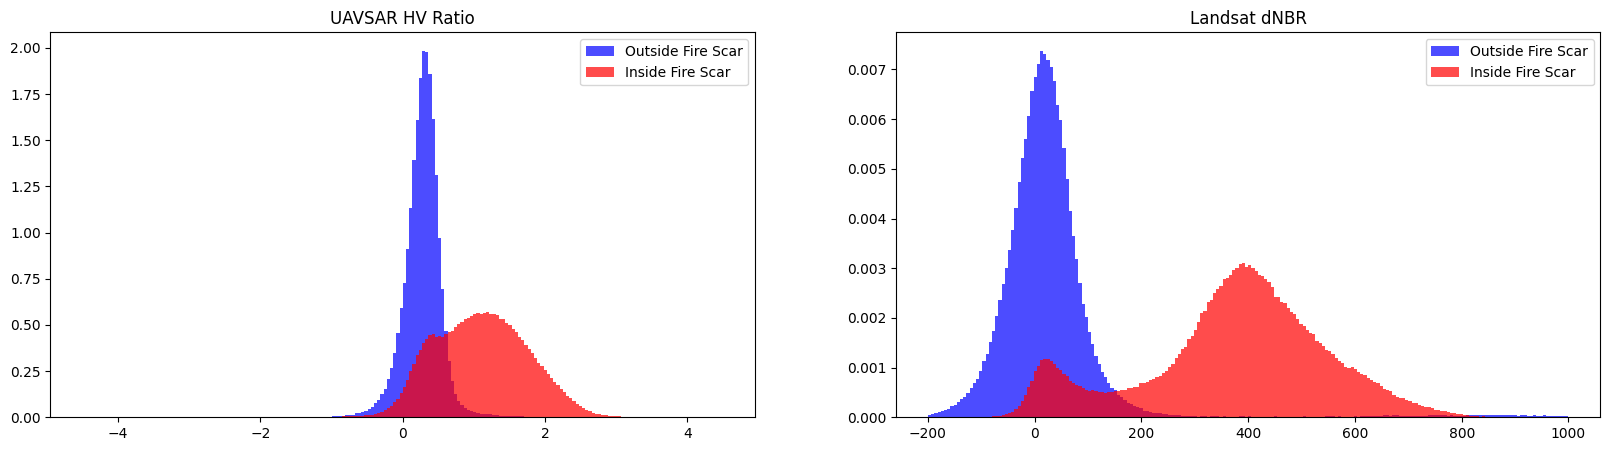

In [45]:
#@title UAVSAR HV Log Ratio & dNBR Histograms
fig, (ax1, ax2)  = plt.subplots(1,2, figsize=(20,5))

HV_log_2014_2017_burned = HV_log_2014_2017[perimeter != 0]
HV_log_2014_2017_notburned = HV_log_2014_2017[verdugos != 0]

dnbr_burned = np.multiply(dnbr, perimeter)
dnbr_burned[dnbr_burned==-9999] = np.nan
dnbr_burned[dnbr_burned==0] = np.nan
dnbr_notburned = np.multiply(dnbr, verdugos)
dnbr_notburned[dnbr_notburned==-9999] = np.nan
dnbr_notburned[dnbr_notburned==0] = np.nan

######################### Histograms #########################
########## UAVSAR 6 meter#############
n_notburned, bins_notburned, patches_notburned = ax1.hist(HV_log_2014_2017_notburned.flatten(), range = [-4.5, 4.5], bins=200, alpha=0.7, density=True,label='Outside Fire Scar', color = "blue")
n_burned, bins_burned, patches_burned = ax1.hist(HV_log_2014_2017_burned.flatten(), range = [-4.5, 4.5], bins=200, alpha=0.7, density=True, label='Inside Fire Scar', color = "red")
ax1.set_title("UAVSAR HV Ratio")
ax1.legend()
print("UAVSAR")

########## dNBR 6 meter#############
n_notburned, bins_notburned, patches_notburned = ax2.hist(dnbr_notburned.flatten(), bins=200, range = [-200, 1000], alpha=0.7, density=True,label="Outside Fire Scar", color = "blue")
n_burned, bins_burned, patches_burned = ax2.hist(dnbr_burned.flatten(), bins=200, alpha=0.7, range = [-200, 1000], density=True,label="Inside Fire Scar", color = "red")
ax2.set_title("Landsat dNBR")
ax2.legend()


<a name="s4"></a>
## 2. Time Series
UAVSAR has collected data over the Verdugo Mountains since 2009, and leveraging this dataset, we can generate a time series plot of HV statistics inside and outside the fire scar. This time series plot shows how the mean and spread of HV values changes over time. The 2017 post-fire collection has the lowest mean for the area inside the fire scar, although interestingly this mean quickly increased in 2018, possibly indicating vegetation recovery.

Notably, unburned areas of the Verdugo Mountains also have lower values in 2014 (pre-fire) and 2017 (post-fire), likely due to the severe drought in California during those years.

In [46]:
#@title Prepare Data for Time Series
## Make geodataframe and get raster stats

#The UAVSAR stack read in below was converted from linear power to decibels (dB). Formula: 10*log10(DN)
def convert_db(data):
  db = 10*(math.log(data))
  return db

img = rio.open("stack_fire.tif")
array=img.read()
df = pd.DataFrame(array.reshape([10,-1]).T, columns=['2009', '2010','2011','2012','2014','2017','2018','2020','verdugos','fire'])
verdugos_df = df.loc[df['verdugos'] == 2]
perimeter_df = df.loc[df['fire'] == 1]

pd.options.mode.chained_assignment = None
perimeter_df ['2014'] = perimeter_df['2014'].apply(convert_db)
verdugos_df['2014'] = verdugos_df['2014'].apply(convert_db)
perimeter_df['2017'] = perimeter_df['2017'].apply(convert_db)
verdugos_df['2017'] = verdugos_df['2017'].apply(convert_db)

perimeter_df_stats = perimeter_df.describe().transpose()
verdugos_df_stats = verdugos_df.describe().transpose()
perimeter_df_stats.index.name = 'Year'
perimeter_df_stats.reset_index(inplace=True)
verdugos_df_stats.index.name = 'Year'
verdugos_df_stats.reset_index(inplace=True)

perimeter_df_stats = perimeter_df_stats.iloc[:8]
verdugos_df_stats = verdugos_df_stats.iloc[:8]
perimeter_df_stats

Year     count       mean        std        min        25%        50%  \
0  2009  745848.0 -20.666151   6.635054 -42.770805 -24.415382 -19.418075   
1  2010  745848.0 -20.251175   6.523628 -41.617771 -23.895718 -18.954889   
2  2011  745848.0 -19.737677   5.832297 -37.709297 -23.511009 -18.757696   
3  2012  745848.0 -19.862925   6.012344 -38.935780 -23.544755 -18.829776   
4  2014  745848.0 -35.943952   9.146047 -80.215988 -40.663257 -34.550736   
5  2017  745848.0 -47.139110  10.520229 -79.545094 -54.889456 -47.336536   
6  2018  745848.0 -22.621531   5.131218 -35.743809 -26.570961 -23.292169   
7  2020  745848.0 -22.697220   5.277463 -37.655666 -26.460325 -22.920212   

         75%        max  
0 -15.795507  11.251516  
1 -15.451772  11.189482  
2 -15.368543   9.409277  
3 -15.403744  11.662669  
4 -29.680724  22.535265  
5 -39.471302  16.801246  
6 -19.179979  10.638227  
7 -19.033489   8.978511

In [47]:
#@title Plot Time Series
fig = go.Figure()
fig.add_trace(go.Scatter(x=perimeter_df_stats["Year"], y=perimeter_df_stats["mean"], name="Inside Fire Scar", error_y=dict(
            type='percent', # value of error bar given in data coordinates
            symmetric=False,
            value=25,
            valueminus=25)))
fig.add_trace(go.Scatter(x=verdugos_df_stats["Year"], y=verdugos_df_stats["mean"], name="Outside Fire Scar", error_y=dict(
            type='percent', # value of error bar given in data coordinates
            symmetric=False,
            value=25,
            valueminus=25)))
fig.update_xaxes(
    dtick="M1",
    tickformat="\n%Y")
fig.update_layout(
    title="Inside vs Outside Fire Scar",
    xaxis_title="Year of UAVSAR Collection",
    yaxis_title="decibels (dB)",
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="Black"))
fig.show()

<a name="s2"></a>
## 3. RGB Multi-Temporal Composite

This RGB composite below uses HV polarized images acquired before, closely after, and a few years after the September 2017 La Tuna Fire in the Verdugo Mountains, Los Angeles, California.

In this RGB composite, the overlay of different polarizations from three different dates in the red, green, and blue channels, allows users to visually classify the relative intensity or contribution of each date. Each polarization is a separate data band generated by the radar, and the different polarizations have unique interactions with the ground cover. The HV polarization has higher values in vegetated areas where there is "volume scattering" and lower values in areas of lost vegetation post-fire.

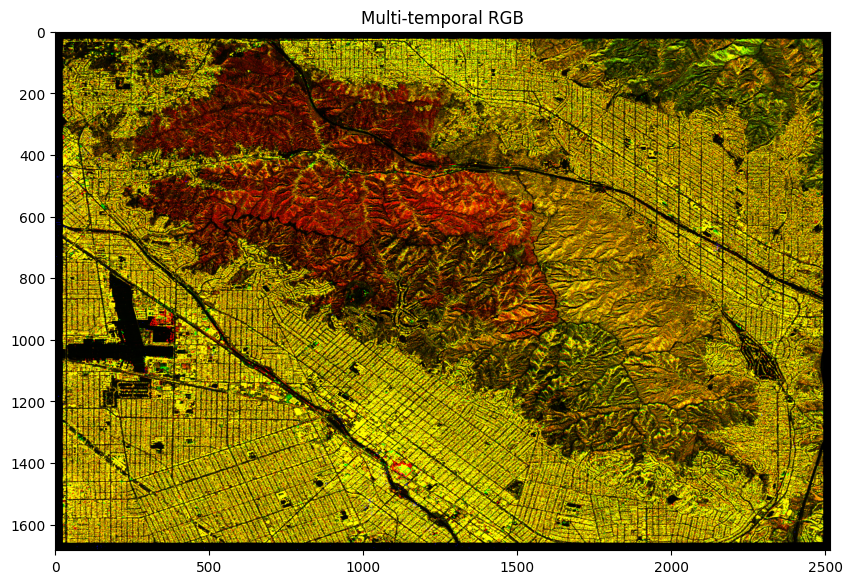

In [59]:
# Define the desired value ranges for each band
min_value_band1 = 0  # Minimum value for the first band
max_value_band1 = 0.1  # Maximum value for the first band

min_value_band2 = 0  # Minimum value for the second band
max_value_band2 = 0.1  # Maximum value for the second band

min_value_band3 = 0  # Minimum value for the third band
max_value_band3 = 0.1  # Maximum value for the third band

# Normalize each band individually to the specified value range
normalized_hv2014 = Normalize(vmin=min_value_band1, vmax=max_value_band1)(hv2014)
normalized_hv2017 = Normalize(vmin=min_value_band2, vmax=max_value_band2)(hv2017)
normalized_hv2020 = Normalize(vmin=min_value_band3, vmax=max_value_band3)(hv2020)


# Stack the normalized bands to create the RGB image
rgb = np.stack((normalized_hv2014, normalized_hv2017, normalized_hv2020), axis=2)

fig, ax = plt.subplots(figsize=(10, 10))
ax.set_title('Multi-temporal RGB')
ax.imshow(rgb)
plt.show()

## Data Download
(Pre-Fire) 2014 Product Pages:
1. https://uavsar.jpl.nasa.gov/cgi-bin/product.pl?jobName=SanAnd_08525_14158_003_141023_L090_CX_01#data
2. https://uavsar.jpl.nasa.gov/cgi-bin/product.pl?jobName=SanAnd_26526_14092_007_140624_L090_CX_01#data

(Post-Fire) 2017 Product Pages:
1. https://uavsar.jpl.nasa.gov/cgi-bin/product.pl?jobName=SanAnd_08525_17122_003_171102_L090_CX_01#data
2. https://uavsar.jpl.nasa.gov/cgi-bin/product.pl?jobName=SanAnd_26526_17122_004_171102_L090_CX_01#data

## USGS BAER Severity Products
1. BAER Products originally downloaded from: https://burnseverity.cr.usgs.gov/viewer/?product=BAER
2. Fire perimeter downloaded from the NIFC: https://data-nifc.opendata.arcgis.com/datasets/historic-perimeters-2017/explore
3. The "not burned" geojson of the Verdugo Mountains was generated by tracing the extent of the mountains
4. Processed UAVSAR and data stacks are staged here: https://uavsar.jpl.nasa.gov/cgi-bin/sar-notebooks.pl

UAVSAR Download: https://uavsar.jpl.nasa.gov/cgi-bin/data.p

ASF: https://search.asf.alaska.edu/#/

 UAVSAR 2014 Product Page:
https://uavsar.jpl.nasa.gov/cgi-bin/product.pl?jobName=SanAnd_08525_14158_003_141023_L090_CX_01#data

UAVSAR 2017 Product Page:
https://uavsar.jpl.nasa.gov/cgi-bin/product.pl?jobName=SanAnd_08525_17122_003_171102_L090_CX_01#data

## Other Resources
NISAR Fire Applications White Paper: https://nisar.jpl.nasa.gov/system/documents/files/13_NISAR_Applications_Fire_Management1.pdf

ESA Document on Polarimetric Decompositions: https://earth.esa.int/documents/653194/656796/Polarimetric_Decompositions.pdf

Polarimetry: https://nisar.jpl.nasa.gov/mission/get-to-know-sar/polarimetry/

## References
1. “La Tuna Fire, City's Biggest by Acreage, Now 80% Contained, Officials Say.” Los Angeles Times, Los Angeles Times, 6 Sept. 2017, www.latimes.com/local/lanow/la-me-ln-verdugo-fire-containment-20170905-story.html.

2. Donnellan, Andrea, et al. “UAVSAR and Optical Analysis of the Thomas Fire Scar and Montecito Debris Flows: Case Study of Methods for Disaster Response Using Remote Sensing Products.” Earth and Space Science, vol. 5, no. 7, 2018, pp. 339–347., doi:10.1029/2018ea000398.

3. Ban, Y. et al. (2020) Near Real-Time Wildfire Progression Monitoring with Sentinel-1 SAR Time Series and Deep Learning. Nature Scientific Reports, 10 (1322).

4. Czuchlewski, K.R. and Weissel, J. K. (2005) Synthetic aperture radar (SAR)-based mapping of wildfire burn severity and recovery. Proceedings: 2005 IEEE International Geoscience and Remote Sensing Symposium.

5. Jung, J., et al. (2018) Damage-Mapping Algorithm Based on Coherence Model Using Multitemporal Polarimetric-Interferometric SAR Data. IEEE Transactions on Geoscience and Remote Sensing 56, 1520–1532.

6. Parker, J., Donnellan, A., & Glasscoe, M. (2021) Survey of Transverse Range Fire Scars in Ten Years of UAVSAR Polarimetry. Wiley.

7. Rains C. (2019) Detection of Fire Burn Scars by UAVSAR: Immediate, Short-term, and Multi-year Observations and Applications. NASA presentation.

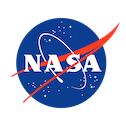

The research was carried out at the Jet Propulsion Laboratory, California Institute of Technology, under a contract with the National Aeronautics and Space Administration (80NM0018D0004)

© 2022. California Institute of Technology. Government sponsorship acknowledged.